In [1]:
# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [2]:
from tqdm.notebook import tqdm

In [3]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS 

In [5]:
import phenom

In [6]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, val):
        super(ThresholdCallback, self).__init__()
        self.val = val
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= self.val:
            self.model.stop_training = True

In [7]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [8]:
def make_training_set(wfs, attr, scale_by_eta=False):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    
    if scale_by_eta:
        eta = phenom.eta_from_q(x)[:, np.newaxis]
        return {'x':x, 'y':y/eta}
    else:
        return {'x':x, 'y':y}

In [9]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt", "IMRPhenomD"]
# approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
# q_max = 2
q_max = 19
# q_min = 19
# q_max = 30
dq = 0.25

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
# npts=5000
# t_min=-500
t_min=-2000
t_max=75

# data_to_model = 'Reh22'
# data_to_model = 'amp'
data_to_model = 'phase'
# data_to_model = 'freq'

# scale_by_eta=True
scale_by_eta=False

In [10]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [11]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts = {}
for approx in approxs:
    model_ts.update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=scale_by_eta)})

In [12]:
common_times = model_wfs[start_approx][0].times

In [13]:
model_ts.keys()

dict_keys(['SEOBNRv4_opt', 'IMRPhenomD'])

In [14]:
model_ts[start_approx].keys()

dict_keys(['x', 'y'])

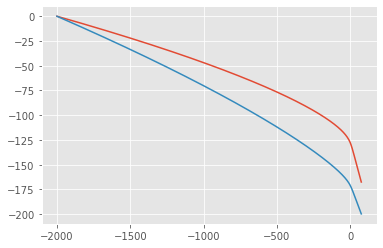

In [15]:
plt.figure()
plt.plot(common_times, model_ts[start_approx]['y'][0])
plt.plot(common_times, model_ts[start_approx]['y'][-1])

In [16]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x = np.concatenate([model_ts[k]['x'] for k in model_ts.keys()])
train_y = np.concatenate([model_ts[k]['y'] for k in model_ts.keys()])

In [17]:
train_y.shape

(144, 1000)

In [18]:
train_y.shape

(144, 1000)

In [19]:
train_x.shape

(144,)

In [20]:
# plt.figure(figsize=(14, 8))
# for i in range(train_y.shape[0]):
#     plt.plot(common_times, train_y[i], label=train_x[i])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.xlim(-100, 100)

# setting up the autoencoder

In [21]:
def build_encoder(input_shape, latent_dim, act="relu"):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape, ))
    x = layers.Dense(128, activation=act)(timeseries_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(16, activation=act)(x)
#     x = layers.Dense(16, activation="tanh")(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_AE = keras.Model(timeseries_input, latent_output)
#     encoder_AE.summary()
    
    return encoder_AE

In [22]:
def build_decoder(latent_dim, act="relu"):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation=act)(latent_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(128, activation=act)(x)
#     x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_AE = keras.Model(latent_input, timeseries_output)
#     decoder_AE.summary()
    
    return decoder_AE

In [23]:
def build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape, ))
    latent = encoder_AE(timeseries_input)
    timeseries_output = decoder_AE(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss='mse')
    
    return ae_model

In [375]:
def check_learning_rate(learning_rate_fn, epochs_array):
    plt.figure()
    plt.plot(list(map(learning_rate_fn, epochs_array)))
    plt.yscale('log')

In [379]:
1200*4

4800

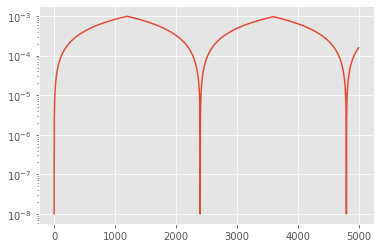

In [388]:
check_learning_rate(tfa.optimizers.ExponentialCyclicalLearningRate(1e-8, 1e-3, 1200, gamma=0.99999), np.arange(5000))

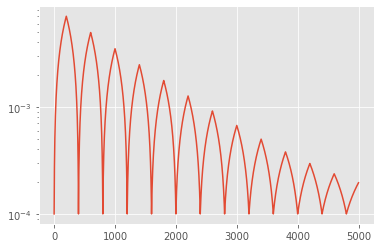

In [471]:
check_learning_rate(tfa.optimizers.ExponentialCyclicalLearningRate(
            initial_learning_rate=1e-4,
            maximal_learning_rate=1e-2,
            step_size=200,
            scale_mode="cycle",
            gamma=0.7), np.arange(5000))

In [763]:
# latent dimension
# latent_dim = 1
latent_dim = 2
# latent_dim = 3
# latent_dim = 4
# latent_dim = 10
# latent_dim = 100

act = "relu"
# act = "tanh"

input_shape = train_y.shape[1] # number of time points

learning_rate=0.001
amsgrad=True
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=amsgrad)
# opt = tfa.optimizers.NovoGrad(learning_rate=learning_rate, amsgrad=amsgrad)
opt = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
# opt = tfa.optimizers.LAMB(learning_rate=learning_rate)
# opt = tfa.optimizers.Yogi(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

# opt = tfa.optimizers.Lookahead(opt)

encoder_AE = build_encoder(input_shape, latent_dim, act)
decoder_AE = build_decoder(latent_dim, act)
ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt)
# encoder_AE.summary()
# decoder_AE.summary()
# ae_model.summary()


callbacks = []

# first_decay_steps = 20
# first_decay_steps = 400
# first_decay_steps = 1200*4
# learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)

# learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(learning_rate, 1e-8, first_decay_steps)
# learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(1e-8, learning_rate, first_decay_steps, gamma=0.999)

initial_learning_rate=1e-6
maximal_learning_rate=1e-2
step_size=200
gamma=0.7
# initial_learning_rate=1e-3
# maximal_learning_rate=1e-2
# step_size=1000
# gamma=1

learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(
            initial_learning_rate=initial_learning_rate,
            maximal_learning_rate=maximal_learning_rate,
            step_size=step_size,
            scale_mode="cycle",
            gamma=gamma)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

callbacks.append(ThresholdCallback(1e-4)) # for the phase if it hasn't been normalised
# callbacks.append(ThresholdCallback(1e-7))

In [764]:
train_y.shape

(144, 1000)

In [765]:
%%time
# epochs=100000
# epochs=1000
# epochs=100000
# epochs=100
epochs=5000
# train the AE
ae_history = ae_model.fit(train_y, train_y, epochs=epochs, callbacks=callbacks, batch_size=32, verbose=0)
# , validation_split=0.2


CPU times: user 2min 56s, sys: 1min 24s, total: 4min 21s
Wall time: 1min 17s


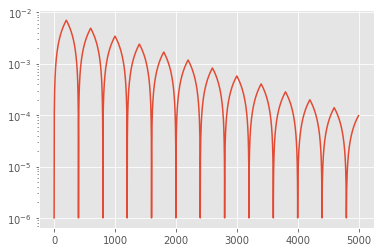

In [766]:
plt.figure()
plt.plot(ae_history.history['lr'])
plt.yscale('log')
# plt.xscale('log')

In [767]:
ae_history.history['loss'][-1]

0.00520491786301136

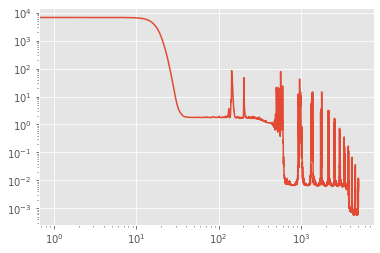

In [768]:
plt.figure()
plt.plot(ae_history.history['loss'])
# plt.plot(ae_history.history['val_loss'])
plt.yscale('log')
plt.xscale('log')

## check out the latent space

In [769]:
train_encodings_AE = encoder_AE.predict(train_y)

In [770]:
train_encodings_AE.shape

(144, 2)

In [771]:
# train_encodings_AE

In [772]:
def plot_latent_space_1d_for_each_model(model_ts, encoder_AE):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])
    
    print(xs.shape)
    print(ys.shape)
    print(latent_space.shape)
    
    for i in range(latent_space.shape[2]):
        plt.figure()
        for n,k in enumerate(model_ts.keys()):
            plt.plot(xs[n], latent_space[n,:,i], '-', label=f'{k}')
        plt.legend()
        plt.title(f'latent space: {i}')
        plt.show()
        plt.close()

(2, 72)
(2, 72, 1000)
(2, 72, 2)


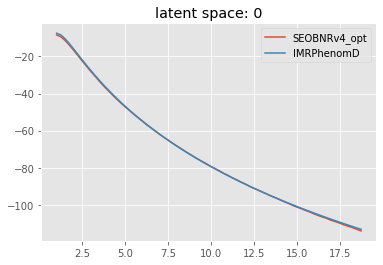

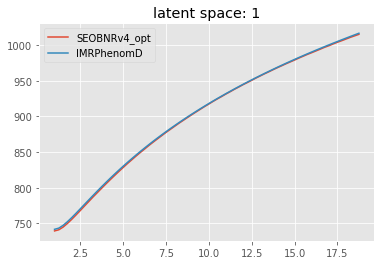

In [773]:
plot_latent_space_1d_for_each_model(model_ts, encoder_AE)

In [774]:
def interpolate_latent_space(model_ts, encoder_AE):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])

    results = {}
    
    for n, k in enumerate(model_ts.keys()):
        interpolations = []
        for i in range(latent_space.shape[2]):
            interpolations.append(IUS(xs[n], latent_space[n,:,i]))
        results.update({k:interpolations})
    
    return results

In [775]:
interpolations = interpolate_latent_space(model_ts, encoder_AE)

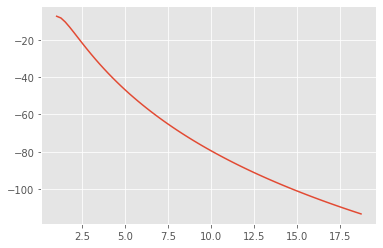

In [776]:
plt.figure()
plt.plot(model_ts['IMRPhenomD']['x'], interpolations['IMRPhenomD'][0](model_ts['IMRPhenomD']['x']))

In [777]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_AE[index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_AE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(common_times, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(common_times, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(common_times, train_y[index], lw=2)
    plt.plot(common_times, decoder_AE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_x[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

In [778]:
def predict_phase(q, decoder_AE, latent_space_interpolations):
    latent_space = np.asarray([f(q) for f in latent_space_interpolations])
    latent_space = latent_space[np.newaxis, :]

    return decoder_AE.predict(latent_space)

In [779]:
yhat = predict_phase(1, decoder_AE, interpolations['IMRPhenomD'])

In [780]:
def generate_case(q, approx="SEOBNRv4_opt", npts=1000, t_min=-2000, t_max=75, data_to_model='phase', scale_by_eta=False):
    model_wf = gen_model_waveforms(approx, [q], npts, t_min=t_min, t_max=t_max)
    return make_training_set(model_wf, data_to_model, scale_by_eta=scale_by_eta)

In [781]:
def compare_model(q, base_model='IMRPhenomD', other_model='SEOBNRv4_opt', data_to_model='phase', scale_by_eta=False):
    yhat = predict_phase(q, decoder_AE, interpolations[base_model])
    test_case = generate_case(q, approx=base_model, data_to_model=data_to_model, scale_by_eta=scale_by_eta)
    
    other_data = generate_case(q, approx=other_model, data_to_model=data_to_model, scale_by_eta=scale_by_eta)
    
    plt.figure(figsize=(22, 8))
    plt.subplot(1,2,1)
    plt.plot(common_times, test_case['y'][0], label=base_model)
    plt.plot(common_times, yhat[0], ls='--', label='decoder')
    plt.plot(common_times, other_data['y'][0], ls='-', label=other_model)
#     plt.xlim(-100, 100)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(common_times, yhat[0]-test_case['y'][0], label=f'decoder - {base_model}')
    plt.plot(common_times, other_data['y'][0]-test_case['y'][0], label=f'{other_model} - {base_model}')
    plt.legend()
    
    plt.suptitle(f'mass-ratio {q}')

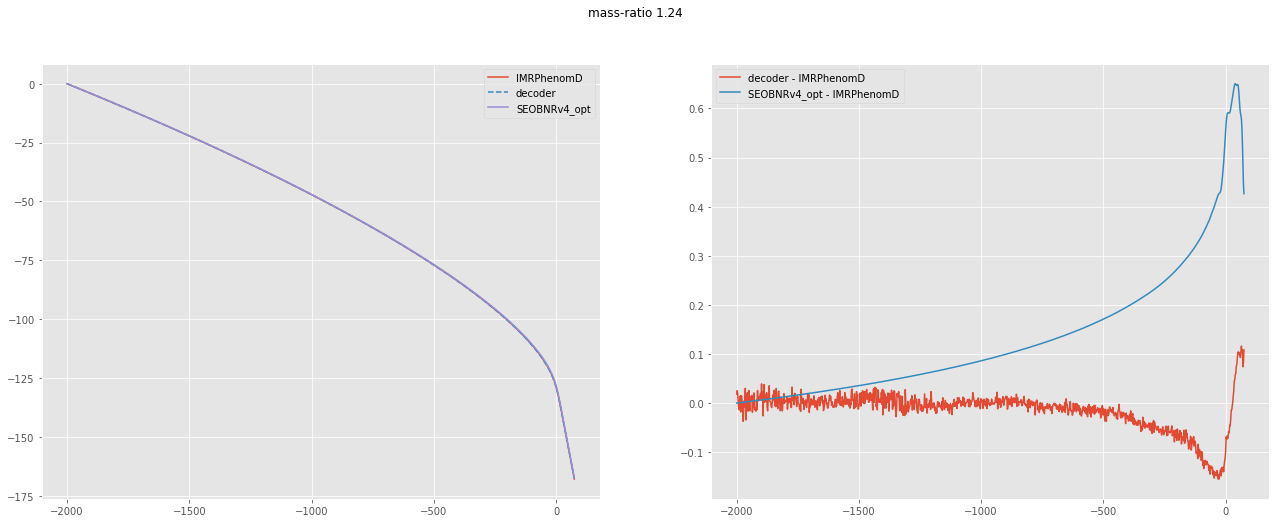

In [782]:
compare_model(1.24, base_model='IMRPhenomD', other_model='SEOBNRv4_opt', data_to_model=data_to_model, scale_by_eta=scale_by_eta)
# compare_model(6.4, base_model='SEOBNRv4_opt', other_model='IMRPhenomD', data_to_model=data_to_model, scale_by_eta=scale_by_eta)

In [783]:
def compare_model_2(q, base_models=['IMRPhenomD', 'SEOBNRv4_opt'], data_to_model='phase', scale_by_eta=False):
    
    yhats = {}
    ys = {}
    for k in base_models:
        yhats.update({k:predict_phase(q, decoder_AE, interpolations[k])})
        ys.update({k:generate_case(q, approx=k, data_to_model=data_to_model, scale_by_eta=scale_by_eta)})
    

    for k in base_models:
        plt.figure(figsize=(12, 4))
        plt.subplot(1,2,1)
        plt.plot(common_times, ys[k]['y'][0], label=k)
        plt.plot(common_times, yhats[k][0], label=f'decoder: {k}', ls='--')
#         plt.xlim(-100, 100)
#         plt.ylim(-200, -150)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(common_times, yhats[k][0]-ys[k]['y'][0], label=f'decoder - true')
        plt.legend()
    
        plt.suptitle(f'mass-ratio {q}')

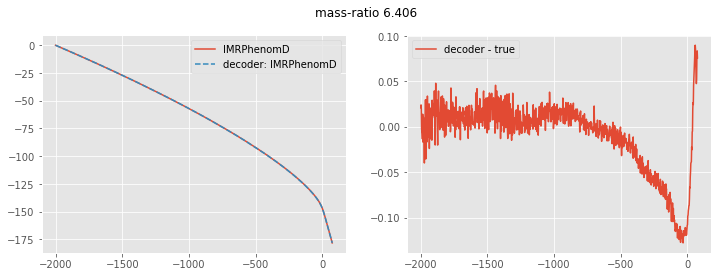

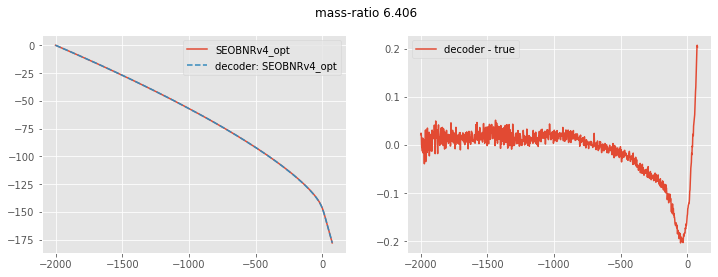

In [784]:
compare_model_2(np.around(np.random.uniform(1, 18), 3))